In [447]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Visualization of brushfire grid, GVD, and paths
def plot_GVD(grid, GVD=None, path=None):
  fig, ax = plt.subplots()
  GVD_grid = np.copy(grid)
  if GVD:
    GVD_x, GVD_y = zip(*GVD)
    GVD_grid[GVD_x,GVD_y] = 20

  img1 = ax.imshow(GVD_grid, cmap="RdBu", alpha=0.6)
  obstacles = GVD_grid.copy()
  obstacles[obstacles < 0] = -2.0
  masked_data = np.ma.masked_where(obstacles > 0, obstacles)
  img2 = ax.imshow(masked_data, cmap="bwr")
  legend_elements = [Patch(facecolor='blue', label='Obstacle')]
  if GVD: legend_elements.append(Patch(facecolor='#83b1d3', label='GVD'))

  if path:
    path_x, path_y = zip(*path)
    GVD_grid[path_x,path_y] = 40.0
    grid_path = GVD_grid.copy()
    grid_path = np.ma.masked_where(grid_path != 40.0, grid_path)
    img3 = ax.imshow(grid_path, cmap="cool_r", interpolation="nearest") 
    legend_elements.append(Patch(facecolor='#e741f6', label='path'))

  ax.legend(handles=legend_elements)
  plt.show()

In [448]:
# Generation of example environments
# Feel free to generate more using these as baseline

def generate_world_1(width=100, height=100):  
  x_list = np.linspace(0, width-1, width)
  y_list = np.linspace(0, height-1, height)  

  grid_world = np.zeros((width, height))
  grid_world = create_rectangle_obstacle(grid_world, 30, 70, 40, 60, -1)

  return grid_world, x_list, y_list


def generate_world_2(width=100, height=100):    
  x_list = np.linspace(0, width-1, width)
  y_list = np.linspace(0, height-1, height)
  
  grid_world = np.zeros((width, height))  
  grid_world = create_rectangle_obstacle(grid_world, 20, 40, 45, 85, -1)
  
  # triangle obstacle
  for x in range(60, 91):
    for y in range(20, 91-x+21):
      grid_world[int(x), int(y)] = -2

  return grid_world, x_list, y_list


def generate_world_3(width=100, height=100):   
  x_list = np.linspace(0, width-1, width)
  y_list = np.linspace(0, height-1, height)
  
  grid_world = np.zeros((width, height))
  grid_world = create_rectangle_obstacle(grid_world, 15, 45, 20, 50, -1)
  grid_world = create_circle_obstacle(grid_world, 75.0, 30.0, 12, -2)
  grid_world = create_circle_obstacle(grid_world, 50.0, 75.0, 16, -3)
  
  return grid_world, x_list, y_list


def generate_world_4(width=100, height=100):   
  x_list = np.linspace(0, width-1, width)
  y_list = np.linspace(0, height-1, height)
  grid_world = np.zeros((width, height))

  # triangle obstacle
  for x in range(50, 81):
    for y in range(20, 21+x-50):
      grid_world[int(x), int(y)] = -1

  grid_world = create_rectangle_obstacle(grid_world, 30, 60, 55, 85, -2)
  grid_world = create_circle_obstacle(grid_world, 25.0, 30.0, 12, -3)
  
  return grid_world, x_list, y_list


def create_circle_obstacle(grid_world, center_x, center_y, radius, obst_id):
  c_x, c_y, r_2 = center_x, center_y, radius
  for x in range(grid_world.shape[0]):
    for y in range(grid_world.shape[1]):
      if np.sqrt((x - c_x)**2 + (y - c_y)**2) < r_2:
        grid_world[int(x), int(y)] = obst_id
  return grid_world


def create_rectangle_obstacle(grid_world, lower_x, upper_x, lower_y, upper_y, obst_id):
  grid_world[lower_x: upper_x, lower_y: upper_y] = obst_id
  return grid_world

In [449]:
z_1, _, _ = generate_world_1()
z_2, _, _ = generate_world_2()
z_3, _, _ = generate_world_3()
z_4, _, _ = generate_world_4()

In [450]:
# Utility functions: You may use or modify any of these

# Return valid neighbors on the grid of cell [i,j]
def neighbors(grid, i, j):
  n = []

  if i-1 >= 0:
    n.append((i-1,j))
    if j-1 >= 0: n.append((i-1,j-1))
    if j+1 < grid.shape[1]: n.append((i-1,j+1))
  if i+1 < grid.shape[0]: 
    n.append((i+1,j))
    if j-1 >= 0: n.append((i+1,j-1))
    if j+1 < grid.shape[1]: n.append((i+1,j+1))
  if j-1 >= 0: n.append((i,j-1))
  if j+1 < grid.shape[1]: n.append((i,j+1))

  return n


# Shortest path from any cell in env to a cell in GVD via gradient ascent
def path_to_GVD(grid, GVD, cell):
  path = [cell]
  while path[-1] not in GVD:
    next = path[-1]
    for n in neighbors(grid, path[-1][0], path[-1][1]):
      if grid[n[0], n[1]] > grid[next[0], next[1]]:
        next = n
    path.append(next)
  return path


# Shortest path between two points on GVD
def GVD_path(grid, GVD, A, B):
  GVD = set(GVD)
  closed = set([])
  open = [A]
  pointers = {}

  while len(open) > 0:
    cell = open.pop(0)
    new_neighbors = GVD.intersection(set(neighbors(grid, cell[0], cell[1]))) - closed

    if B in new_neighbors:
      pointers[B] = cell
      path = [B]
      while path[-1] != A:
        next = pointers[path[-1]]
        path.append(next)
      return list(reversed(path))

    open += list(new_neighbors)
    closed.update(new_neighbors)
    pointers.update(dict.fromkeys(list(new_neighbors), cell))

  return None

In [451]:
def brushfire_path(grid, start, goal):
    currentList = []# format: [which obstacle, x, y]
    newGrid = grid

    GVD = []
    GVD_dict = {}

    #Account for all walls
    currentObstacle = []
    currentObstacle2 = []
    yLength = len(grid[0])
    for i in range(len(grid)):
        if grid[i][0] == 0:
            currentObstacle.append([i,0])
            newGrid[i][0] = 1
        if grid[i][yLength-1] == 0:
            currentObstacle2.append([i,yLength-1])
            newGrid[i][yLength-1] = 1
    currentList.append(currentObstacle)
    currentList.append(currentObstacle2)
    
    currentObstacle = []
    currentObstacle2 = []
    xLength = len(grid)
    for i in range(len(grid[0])):
        if grid[0][i] == 0:
            currentObstacle.append([0, i])
            newGrid[0][i] = 1
        if grid[xLength-1][i] == 0:
            currentObstacle2.append([xLength-1,i])
            newGrid[xLength-1][i] = 1
    currentList.append(currentObstacle)
    currentList.append(currentObstacle2)

    if grid[0][0] == 0:
        GVD.append((0,0))
        GVD_dict[(0,0)]=1
    if grid[xLength-1][0] == 0:
        GVD.append((xLength-1,0))
        GVD_dict[(xLength-1,0)]=1
    if grid[0][yLength-1] == 0:
        GVD.append((0,yLength-1))
        GVD_dict[(0,yLength-1)]=1
    if grid[xLength-1][yLength-1] == 0:
        GVD.append((xLength-1,yLength-1))
        GVD_dict[(xLength-1,yLength-1)]=1

    #Account for all obstacles
    currentObstacles = []#list of lists
    existDict = {}
    for i in range(len(grid)):
        for j in range(len(grid[0])):
            if grid[i][j] < 0:
                continue
            neigh = neighbors(grid,i,j)
            whichObstacle = 0
            for k in range(len(neigh)):
                if grid[neigh[k][0]][neigh[k][1]] < 0:
                    whichObstacle = -1*grid[neigh[k][0]][neigh[k][1]]
            if whichObstacle != 0:
                if whichObstacle in existDict:
                    currentObstacles[existDict[whichObstacle]].append([i,j])
                else:
                    currentObstacles.append([[i,j]])
                    existDict[whichObstacle] = len(currentObstacles) - 1
                newGrid[i][j] = 1

    for i in range(len(currentObstacles)):
        currentList.append(currentObstacles[i])

    step = 2
    while len(currentList) > 0:
        nextList = []
        hitDict = {}
        for i in range(len(currentList)):
            nextObstacle = []
            for k in range(len(currentList[i])):#k would be the element in each obstacle
                neigh = neighbors(newGrid,currentList[i][k][0],currentList[i][k][1])
                smallDict = {}
                for j in range(len(neigh)):
                    if (neigh[j][0],neigh[j][1]) in hitDict:
                        if hitDict[(neigh[j][0],neigh[j][1])] != i:
                            if not((neigh[j][0],neigh[j][1]) in GVD):
                                GVD.append((neigh[j][0],neigh[j][1]))
                    else:
                        hitDict[(neigh[j][0],neigh[j][1])] = i
                    if newGrid[neigh[j][0]][neigh[j][1]] == 0 or newGrid[neigh[j][0]][neigh[j][1]] == step:
                        newGrid[neigh[j][0]][neigh[j][1]] = step
                        if not([neigh[j][0],neigh[j][1]] in nextObstacle):
                            nextObstacle.append([neigh[j][0], neigh[j][1]])
                            smallDict[(neigh[j][0],neigh[j][1])] = 1
            if len(nextObstacle) >= 1:
                nextList.append(nextObstacle)
        currentList = nextList
        step += 1

    path1 = path_to_GVD(newGrid,GVD,start)
    

    path3_reverse = path_to_GVD(newGrid,GVD,goal)
    path3 = []
    for i in range(len(path3_reverse)):
        path3.append(path3_reverse[len(path3_reverse)-1-i])
    path2 = GVD_path(newGrid,GVD,path1[len(path1)-1], path3[0])

    path1.extend(path2)
    path1.extend(path3)

    return newGrid, GVD, path1

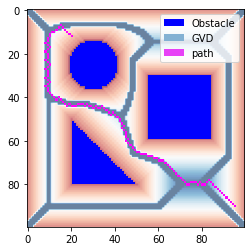

In [452]:
grid = z_4

start = (12,20)
goal = (90,95)
grid, GVD, path = brushfire_path(grid, start, goal)
plot_GVD(grid, GVD, path)
